# PHYS366: Statistical Methods in Astrophysics


# Lesson 3: Inference in Practice: PDF Characterization

### Goals for this session:

* Linear problems: General solution + short cuts. When and why do these short cuts work?
* Introduction to Monte Carlo Methods
* Convergence tests

Adapted from [straight line notebook](https://github.com/drphilmarshall/LearningInference/blob/master/straightline.ipynb) by Phil Marshall and Dustin Lang
#### Related reading:
* Ivezic Ch. 8.1, 8.2, 8.8
* MacKay Ch. 12


# The Data Set
Today we will explore different methods to fit a model to data, and when these methods break.

The latter will require us to vary the input, e.g. re-running the same method with different error bars. 
I don't want to instruct you to tweak the error bars of an astronomical data set, so today we'll just load a synthetic set of points.

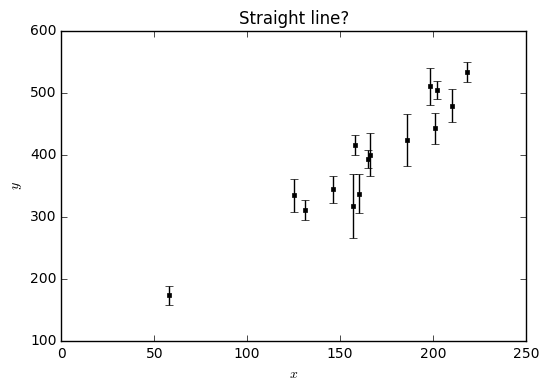

In [3]:
import numpy as np
from straightline_utils import *
%matplotlib inline
from matplotlib import rcParams
rcParams['savefig.dpi'] = 100
(x,y,sigmay) = get_data_no_outliers()
plot_yerr(x, y, sigmay)

# Bayesian Solution: Posterior distribution of model parameters

This looks like data points scattered around a straight line,

$y = b + m x$.

If the error distribution in $y$ is Gaussian, the data likelihood for a specific linear model $(m,b)$ is given by

$P(\{x_i,y_i,\sigma_{y_i}\}|(m,b)) = \Pi_i\frac{1}{\sqrt{2\pi}\sigma_{y_i}} \exp[-1/2(y_i-(b+m x_i) )^2/\sigma_{y_i}^2]$.

Assuming a flat prior PDF for the model parameters, the posterior PDF of model parameters $(m, b)$ is directly proportional to the data likelihood. We can test this model by determining the parameter log-likelihood

$\ln(L((m,b)|\{x_i,y_i,\sigma_{y_i}\})\propto \sum_i -1/2(y_i-(b+m x_i) )^2/\sigma_{y_i}^2$

on a parameter grid, which captures the uncertainty in the model parameters given the data. For simple, 2-dimensional parameter spaces like this one, evaluating on a grid is not a bad way to go.

In [5]:
def straight_line_log_likelihood(x, y, sigmay, m, b):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y_t = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept

    Returns: scalar log likelihood
    '''
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / sigmay**2))
    
def straight_line_log_prior(m, b):
    return 0.
    
def straight_line_log_posterior(x,y,sigmay, m,b):
    return (straight_line_log_likelihood(x,y,sigmay, m,b) +
            straight_line_log_prior(m, b))



Grid maximum posterior values: 27.0 2.28888888889


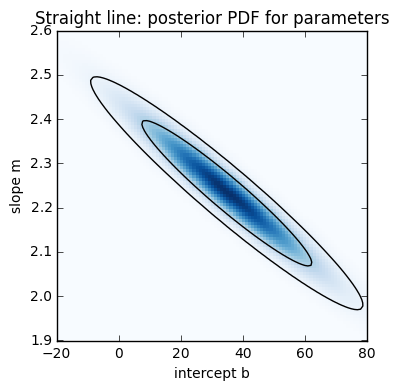

In [6]:
# Evaluate log P(m,b | x,y,sigmay) on a grid.
# Set up grid
mgrid = np.linspace(mlo, mhi, 100)
bgrid = np.linspace(blo, bhi, 101)
log_posterior = np.zeros((len(mgrid),len(bgrid)))
# Evaluate log probability on grid
for im,m in enumerate(mgrid):
    for ib,b in enumerate(bgrid):
        log_posterior[im,ib] = straight_line_log_posterior(x, y, sigmay, m, b)
# Convert to probability density and plot
posterior = np.exp(log_posterior - log_posterior.max())
plt.imshow(posterior, extent=[blo,bhi, mlo,mhi],cmap='Blues',
           interpolation='nearest', origin='lower', aspect=(bhi-blo)/(mhi-mlo),
           vmin=0, vmax=1)
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')

i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print 'Grid maximum posterior values:', bgrid[i], mgrid[j]

plt.title('Straight line: posterior PDF for parameters');
#plt.plot(b_ls, m_ls, 'w+', ms=12, mew=4);
plot_mb_setup();

## Short Cut #1: Linear Least Squares
An industry standard: find the slope $m_{\mathrm{LS}}$ and intercept $b_{\mathrm{LS}}$ that minimize the mean square residual
$S(m,b) = \sum_i[y_i-(b+m x_i)]^2/\sigma_{y_i}^2$:

$\frac{\partial S}{\partial b}|_{b_{\mathrm{LS}}} =0 = -2\sum_i[y_i-(b_{\mathrm{LS}}+m_{\mathrm{LS}} x_i) ]/\sigma_{y_i}^2$,   
$\frac{\partial S}{\partial m}|_{m_{\mathrm{LS}}} = 0 = -2\sum_i [y_i-(b_{\mathrm{LS}}+m_{\mathrm{LS}} x_i )]x_i/\sigma_{y_i}^2$.

## Derive the solution for homoscedastic (i.e. $\sigma_i = \sigma$) data
* What are the expressions for the fit parameters?

* How about the parameter uncertainties?


Since the data depend linearly on the parameters, also the heteroscedastic least squares solution can be found by a matrix inversion and multiplication, this is conveneniently packed in `numpy.linalg.lstsq` (though this doesn't include parameter uncertainties).

Least Squares (maximum likelihood) estimator: 34.8459413134 2.23253621695


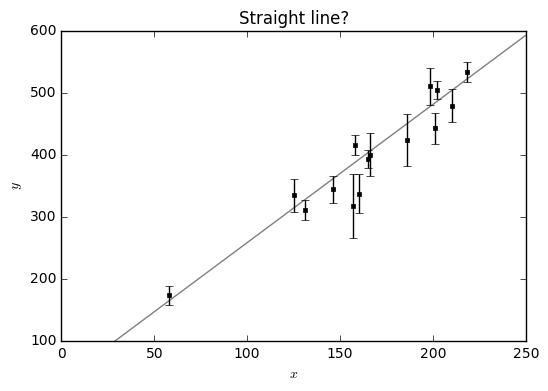

In [7]:
# Linear algebra: weighted least squares
N = len(x)
A = np.zeros((N,2))
A[:,0] = 1. / sigmay
A[:,1] =  x / sigmay
b = y / sigmay
theta,nil,nil,nil = np.linalg.lstsq(A, b)
plot_yerr(x, y, sigmay)
b_ls,m_ls = theta
print 'Least Squares (maximum likelihood) estimator:', b_ls,m_ls
plot_line(m_ls, b_ls);

Similarly, one can derived expressions for the uncertainty for of the least squares fit parameters, c.f. Ivezic Ch. 8.2. These expressions can be thought of as propagating the data error into parameter errors (using standard error propagation, i.e. chain rule).

The linear least squares estimator is a __maximum likelihood estimator__ for linear model parameters, based on the assumption on Gaussian distributed data.


## Short Cut #2: Laplace Approximation (Blackboard)
MacKay Chapter 12; 

Approximation to 

# Monte Carlo Sampling Methods

In problems with higher dimensional parameter spaces, we need a more efficient way of approximating the posterior PDF - both when characterizing it in the first place, and then when doing integrals over that PDF (to get the marginalized PDFs for the parameters, or to compress them in to single numbers with uncertainties that can be easily reported). In most applications it's sufficient to approximate a PDF with a (relatively) small number of samples drawn from it; MCMC is a procedure for drawing samples from PDFs.

In [16]:
def straight_line_posterior(x, y, sigmay, m, b):
    return np.exp(straight_line_log_posterior(x, y, sigmay, m, b))

In [32]:
# initial m, b
m,b = 2., 0.

# step sizes
mstep, bstep = 0.1, 10.
        
# how many steps?
nsteps = 10000
    
chain = []
probs = []
naccept = 0
    
print 'Running MH for', nsteps, 'steps'

# First point:
L_old    = straight_line_log_likelihood(x, y, sigmay, m, b)
p_old    = straight_line_log_prior(m, b)
prob_old = np.exp(L_old + p_old)

for i in range(nsteps):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep

    # evaluate probabilities
    # prob_new = straight_line_posterior(x, y, sigmay, mnew, bnew)

    L_new    = straight_line_log_likelihood(x, y, sigmay, mnew, bnew)
    p_new    = straight_line_log_prior(mnew, bnew)
    prob_new = np.exp(L_new + p_new)

    if (prob_new / prob_old > np.random.uniform()):
        # accept
        m = mnew
        b = bnew
        L_old = L_new
        p_old = p_new
        prob_old = prob_new
        naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain.append((b,m))
    probs.append((L_old,p_old))
print 'Acceptance fraction:', naccept/float(nsteps)


Running MH for 10000 steps
Acceptance fraction: 0.2889


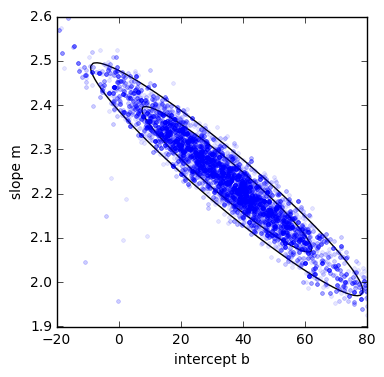

In [29]:
# Pull m and b arrays out of the Markov chain and plot them:
mm = [m for b,m in chain]
bb = [b for b,m in chain]
# Scatterplot of m,b posterior samples
plt.clf()
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')
plt.gca().set_aspect((bhi-blo)/(mhi-mlo))
plt.plot(bb, mm, 'b.', alpha=0.1)
plot_mb_setup()
plt.show()

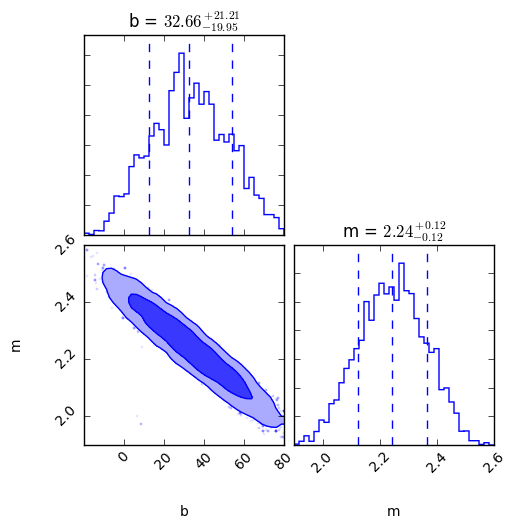

In [12]:
# 1 and 2D marginalised distributions:
import triangle
triangle.corner(chain, labels=['b','m'], range=[(blo,bhi),(mlo,mhi)],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.show()

## Convergence tests
We expect our chains to
eventually converge to the stationary distribution, which is also our
target distribution.
However, there is no guarantee that our chain has converged after
`nsteps`
draws.

*How do we know whether our chain has actually converged?*

We can never be sure, but there are several tests we can do, both
visual and statistical, to see if the chain _appears_ to be converged.

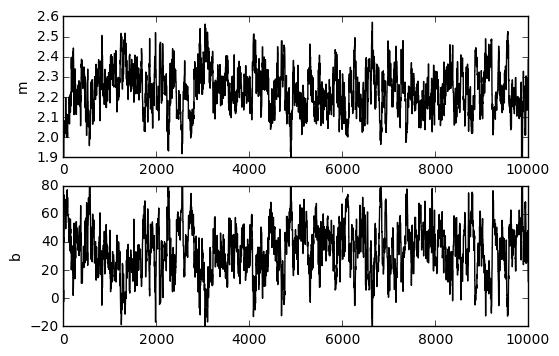

In [21]:
# Traces, for convergence inspection:
plt.clf()
plt.subplot(2,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlo,mhi)
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'k-')
plt.ylabel('b')
plt.ylim(blo,bhi)
plt.show()

For comparison, run a second chain with different step sizes:

Running MH for 10000 steps
Acceptance fraction: 0.0794


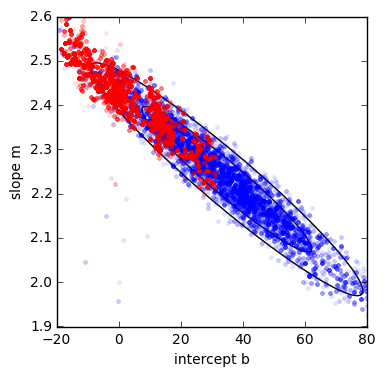

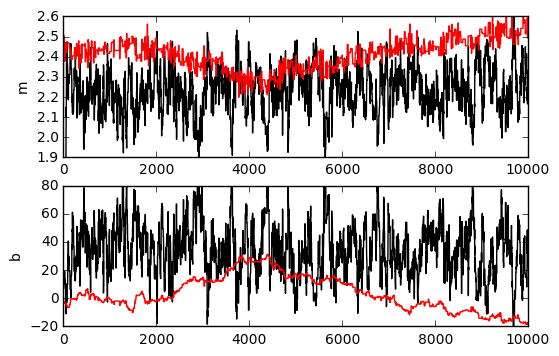

In [49]:
# initial m, b
m,b = 2., 0.

# step sizes
mstep, bstep = .5, 1.
        
# how many steps?
nsteps = 10000
    
chain2 = []
probs2 = []
naccept = 0
    
print 'Running MH for', nsteps, 'steps'

# First point:
L_old    = straight_line_log_likelihood(x, y, sigmay, m, b)
p_old    = straight_line_log_prior(m, b)
prob_old = np.exp(L_old + p_old)

for i in range(nsteps):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep

    # evaluate probabilities
    # prob_new = straight_line_posterior(x, y, sigmay, mnew, bnew)

    L_new    = straight_line_log_likelihood(x, y, sigmay, mnew, bnew)
    p_new    = straight_line_log_prior(mnew, bnew)
    prob_new = np.exp(L_new + p_new)

    if (prob_new / prob_old > np.random.uniform()):
        # accept
        m = mnew
        b = bnew
        L_old = L_new
        p_old = p_new
        prob_old = prob_new
        naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain2.append((b,m))
    probs2.append((L_old,p_old))
print 'Acceptance fraction:', naccept/float(nsteps)

mm2 = [m for b,m in chain2]
bb2 = [b for b,m in chain2]
# Scatterplot of m,b posterior samples
plt.clf()
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')
plt.gca().set_aspect((bhi-blo)/(mhi-mlo))
plt.plot(bb, mm, 'b.', alpha=0.1)
plt.plot(bb2, mm2, 'r.', alpha=0.1)
plot_mb_setup()
plt.show()
# Traces, for convergence inspection:
plt.clf()
plt.subplot(2,1,1)
plt.plot(mm, 'k-')
plt.plot(mm2, 'r-')
plt.ylim(mlo,mhi)
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'k-')
plt.plot(bb2, 'r-')
plt.ylabel('b')
plt.ylim(blo,bhi)
plt.show()


## Criterion 1: Autocorrelation
One common way to asses convergence of a chain is by assessing the autocorrelations between draws of the chain:

The lag $k$ autocorrelation $\rho_k$ is the correlation between every draw and its $k$th lag:

$\rho_k = \frac{\sum_{i = 1}^{\mathrm{nsteps}-k}\left(\theta_{i} - \bar{\theta}\right)\left(\theta_{i+k} - \bar{\theta}\right)}{\sum_{i = 1}^{\mathrm{nsteps}}\left(\theta_{i} - \bar{\theta}\right)^2}$

One expects the $k$th lag autocorrelation to decrease as $k$ increases. If $\rho_k$ is still relatively high for high $k$ values, this indicates a high degree of correlation across the chain and slow mixing. 

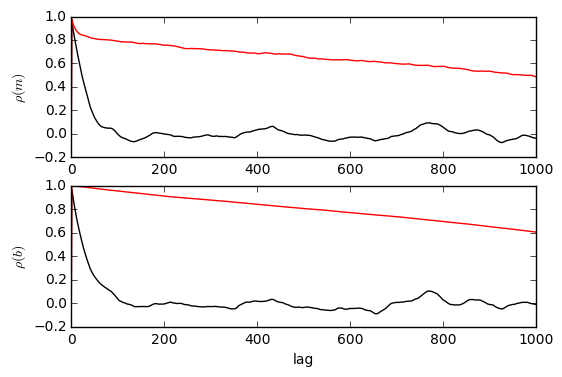

In [59]:
def autocor (chain, kmax):
    x = chain - np.mean(chain)
    cor = np.zeros(kmax)
    for k in range(1,kmax):
      cor[k] = np.sum(x[0:-k]*x[k:])/np.sum(x*x)
    return cor

kmax = 1000

plt.clf()
plt.subplot(2,1,1)
plt.plot(autocor(mm,kmax), 'k-')
plt.plot(autocor(mm2,kmax), 'r-')
plt.ylabel(r'$\rho(m)$')
plt.subplot(2,1,2)
plt.plot(autocor(bb,kmax), 'k-')
plt.plot(autocor(bb2,kmax), 'r-')
plt.ylabel(r'$\rho(b)$')
plt.xlabel('lag')
plt.show()


## Criterion 2: Gelman-Rubin